In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sb
import time


In [17]:
def prep_data(phenotype) :
    pheno = pd.read_csv('./input/gono-unitigs/metadata.csv', index_col=0)
    pheno = pheno.dropna(subset=[phenotype]) # drop samples that don't have a value for our chosen resistance profile
    pheno = pheno[phenotype]
        
    # read in unitig data
    X = pd.read_csv('./input/gono-unitigs/' + phenotype + '_gwas_filtered_unitigs.Rtab', sep=" ", index_col=0, low_memory=False)
    X = X.transpose()
    X = X[X.index.isin(pheno.index)] # only keep rows with a resistance measure
    pheno = pheno[pheno.index.isin(X.index)]
    return X, pheno


In [18]:
# prepare our data for predicting antibiotic resistance
phenotype = 'azm_sr'
X, pheno = prep_data(phenotype)

# create an array for storing performance metrics
performance = {
    "balanced_accuracy": [],
    "accuracy": [],
    "average_precision": [],
    "f1_score": [],
    "precision": [],
    "recall": []
}
method = []
times = []


<AxesSubplot:ylabel='Density'>

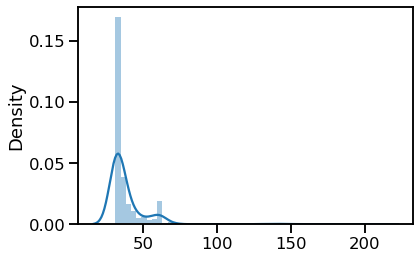

In [19]:
unitigs = X.columns
mylen = np.vectorize(len)
uni_len = mylen(unitigs)
sb.distplot(uni_len)


In [20]:
def fitmodel(X, pheno, estimator, parameters, modelname, method, performance, times) :
    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        # time how long it takes to train each model type
        start = time.process_time()
        
        # split data into train/test sets
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
        # perform grid search to identify best hyper-parameters
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)
        
        # predict resistance in test set
        y_pred = gs_clf.predict(X_test)
        y_pred[y_pred<0.5] = 0
        y_pred[y_pred>0.5] = 1

        score = balanced_accuracy_score(y_test, y_pred)
        performance["balanced_accuracy"] = np.append(performance["balanced_accuracy"], score)

        score = accuracy_score(y_test, y_pred)
        performance["accuracy"] = np.append(performance["accuracy"], score)

        score = average_precision_score(y_test, y_pred)
        performance["average_precision"] = np.append(performance["average_precision"], score)

        score = f1_score(y_test, y_pred)
        performance["f1_score"] = np.append(performance["f1_score"], score)

        score = precision_score(y_test, y_pred)
        performance["precision"] = np.append(performance["precision"], score)

        score = recall_score(y_test, y_pred)
        performance["recall"] = np.append(performance["recall"], score)

        method = np.append(method, modelname)
        times = np.append(times, (time.process_time() - start))

        print("Best hyperparameters for this fold")
        print(gs_clf.best_params_)
        print("Confusion matrix for this fold")
        print(confusion_matrix(y_test, y_pred))
    return gs_clf, method, performance, times


In [21]:
enet = SGDClassifier(loss="log", penalty="elasticnet")
enet_params = {
    'l1_ratio': [0.1, 0.2, 0.5]
}

enet_model, method, performance, times = fitmodel(X, pheno, enet, enet_params, "Elastic net", method, performance, times)


Best hyperparameters for this fold
{'l1_ratio': 0.2}
Confusion matrix for this fold
[[539  11]
 [ 35 111]]
Best hyperparameters for this fold
{'l1_ratio': 0.2}
Confusion matrix for this fold
[[686   2]
 [  2   6]]
Best hyperparameters for this fold
{'l1_ratio': 0.5}
Confusion matrix for this fold
[[642   7]
 [  9  38]]
Best hyperparameters for this fold
{'l1_ratio': 0.5}
Confusion matrix for this fold
[[593  32]
 [ 17  53]]
Best hyperparameters for this fold
{'l1_ratio': 0.5}
Confusion matrix for this fold
[[488  31]
 [ 13 163]]


In [22]:
svm = SVC(class_weight='balanced')
svm_params = {
    'C': [0.01],
    'gamma': [1e-06, 1e-05],
    'kernel': ['linear']
}

svm_model, method, performance, times = fitmodel(X, pheno, svm, svm_params, "Support vector machine", method, performance, times)


Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[538  12]
 [ 15 131]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[687   1]
 [  0   8]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[638  11]
 [  2  45]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[590  35]
 [  5  65]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[505  14]
 [  6 170]]


In [23]:
xgb_mod = xgb.XGBClassifier(random_state=0)
xgb_params = {
    'alpha': [1e-5, 1e-4], 
    'colsample_bytree': [0.6],
    'gamma': [0.05, 0.1], 
    'learning_rate': [0.01, 0.1], 
    'max_depth': [2], 
    'objective': ['binary:hinge'], 
    'subsample': [0.2, 0.4, 0.6]
}

xgb_model, method, performance, times = fitmodel(X, pheno, xgb_mod, xgb_params, "XGBoost", method, performance, times)


Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.4}
Confusion matrix for this fold
[[536  14]
 [ 15 131]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[686   2]
 [  0   8]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[636  13]
 [  2  45]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.4}
Confusion matrix for this fold
[[590  35]
 [  5  65]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 

In [24]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
rf_params = {
    'max_features': [round(X.shape[1]*0.1), round(X.shape[1]*0.5), round(X.shape[1]*0.8)],
    'max_depth': [3],
    'n_estimators': [50]
}

rf_model, method, performance, times = fitmodel(X, pheno, rf, rf_params, "Random forest", method, performance, times)


Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 412, 'n_estimators': 50}
Confusion matrix for this fold
[[538  12]
 [ 15 131]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[681   7]
 [  0   8]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[637  12]
 [  2  45]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[588  37]
 [  5  65]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[505  14]
 [  6 170]]


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Elastic net'),
  Text(1, 0, 'Support vector machine'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'Random forest')])

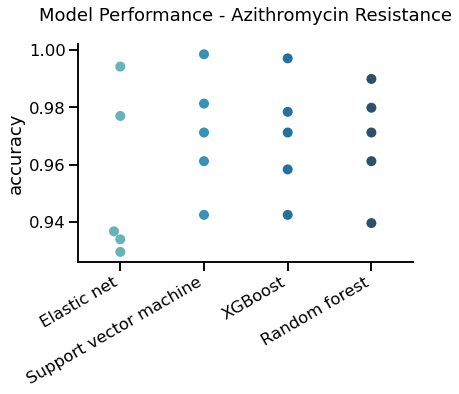

In [25]:
sb.set_context("talk")
plt.title("Model Performance - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=performance["accuracy"], palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("accuracy")
plt.xticks(rotation=30, ha='right')


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Elastic net'),
  Text(1, 0, 'Support vector machine'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'Random forest')])

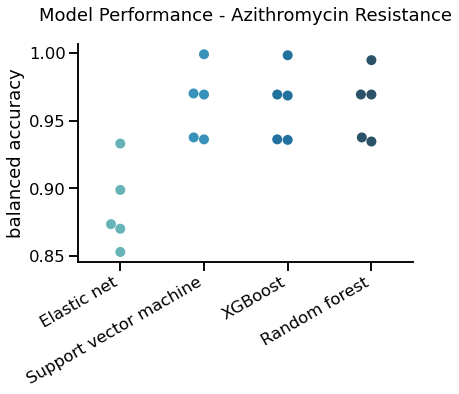

In [26]:
# compare results from the different predictors
sb.set_context("talk")
plt.title("Model Performance - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=performance["balanced_accuracy"], palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("balanced accuracy")
plt.xticks(rotation=30, ha='right')


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Elastic net'),
  Text(1, 0, 'Support vector machine'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'Random forest')])

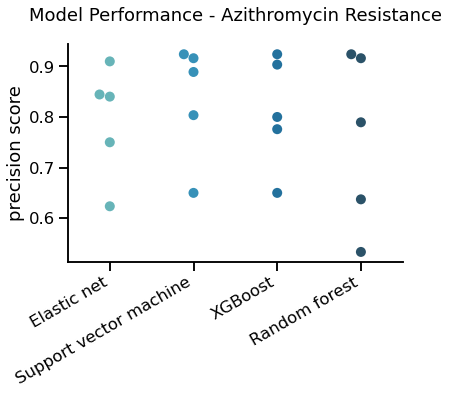

In [27]:
sb.set_context("talk")
plt.title("Model Performance - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=performance["precision"], palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("precision score")
plt.xticks(rotation=30, ha='right')


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Elastic net'),
  Text(1, 0, 'Support vector machine'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'Random forest')])

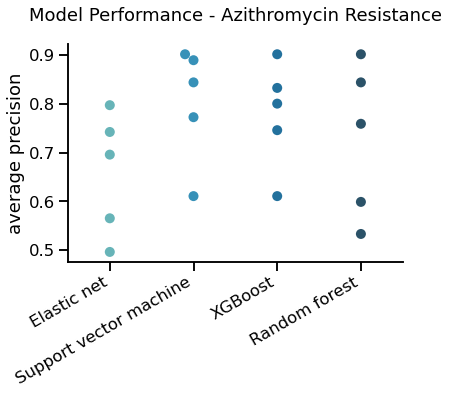

In [28]:
sb.set_context("talk")
plt.title("Model Performance - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=performance["average_precision"], palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("average precision")
plt.xticks(rotation=30, ha='right')


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Elastic net'),
  Text(1, 0, 'Support vector machine'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'Random forest')])

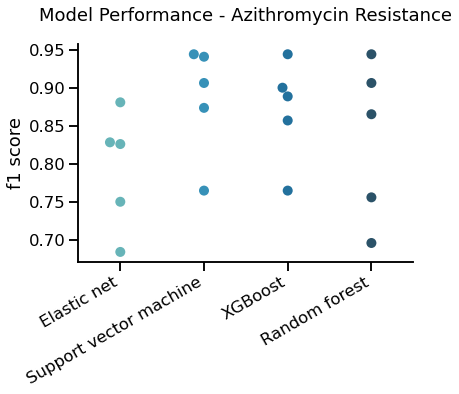

In [29]:
sb.set_context("talk")
plt.title("Model Performance - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=performance["f1_score"], palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("f1 score")
plt.xticks(rotation=30, ha='right')


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Elastic net'),
  Text(1, 0, 'Support vector machine'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'Random forest')])

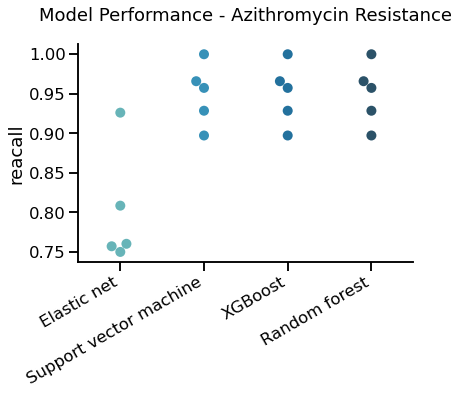

In [30]:
sb.set_context("talk")
plt.title("Model Performance - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=performance["recall"], palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("reacall")
plt.xticks(rotation=30, ha='right')
